In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
class Gridworld:
    def __init__(self,row,column,probability,action_reward):
        self.value_grid = np.zeros((row,column))
        self.grid = np.zeros((row,column)).astype(str)
        self.probability = probability
        self.action_reward = action_reward
        
    def print_grid(self):
        for row in self.grid:
            print(row)
        print("")

    def add_lion(self,lion_location):
        self.lion_location = lion_location
        self.grid[lion_location[0],lion_location[1]] = "L"
        
    def add_deer_hunter(self,deer_location,reward,hunter_location,punishment):
        n,m = np.shape(self.grid)
        #location = random.sample(range(1,(n*m)), 2)
        #self.deer_location = [location[0]//n,location[0]%n]
        self.deer_location = deer_location
        self.deer_reward = reward
        self.grid[deer_location[0],deer_location[1]] = 'D'
        self.value_grid[deer_location[0],deer_location[1]] = reward
        self.grid[hunter_location[0],hunter_location[1]] = 'H'
        self.hunter_location = hunter_location
        self.hunter_punishment = punishment
        self.value_grid[hunter_location[0],hunter_location[1]] = punishment
        
    def get_value(self,current_location,direction):
        if Gridworld.valid_direction(self,current_location,direction) == False:
            return self.value_grid[current_location[0],current_location[1]]
        elif direction == 'north':
            return self.value_grid[current_location[0]-1,current_location[1]]
        elif direction == 'south':
            return self.value_grid[current_location[0]+1,current_location[1]]
        elif direction == 'east':
            return self.value_grid[current_location[0],current_location[1]+1]
        elif direction == 'west':
            return self.value_grid[current_location[0],current_location[1]-1]
            
    def valid_direction(self,current_location,direction):
        if direction == 'north':
            if current_location[0] != 0:
                return True
            else:
                return False
        if direction == 'south':
            if current_location[0] != (self.value_grid.shape[0]-1):
                return True
            else:
                return False
        if direction == 'west':
            if current_location[1] != 0:
                return True
            else:
                return False
        if direction == 'east':
            if current_location[1] != (self.value_grid.shape[1]-1):
                return True
            else:
                return False 
                
    def check_state(self):
        if self.lion_location == self.deer_location:
            raise Exception("Lion caught the deer!")
        elif self.lion_location == self.deer_location:
            raise Exception("Lion shot by hunter!")
        else:
            return True

In [2]:
class ValueIteration(Gridworld):
    def __init__(self,gridworld):
        self.probability = gridworld.probability
        self.deer_location = gridworld.deer_location
        self.deer_reward = gridworld.deer_reward
        self.hunter_location = gridworld.hunter_location
        self.hunter_reward = gridworld.hunter_punishment
        self.value_grid = gridworld.value_grid
        self.action_reward = gridworld.action_reward

    def print_valuegrid(self):
        for row in self.value_grid:
            print(row)
        print("")
        
    def value_iteration(self, discount, delta = 0.000001, max_iteration = 100):
        deer_location = self.deer_location
        hunter_location = self.hunter_location
        current_grid = self.value_grid
        new_grid = np.zeros(self.value_grid.shape)
        performance = []
        for x in range(max_iteration):
            for i in range(self.value_grid.shape[0]):
                for y in range(self.value_grid.shape[1]):
                    if [i,y] == deer_location or [i,y] == hunter_location:
                        new_grid[i,y] = current_grid[i,y]
                    else:
                        new_grid[i,y] = self.max_value([i,y],discount)
            performance.append(np.absolute(new_grid - current_grid).max())
            if np.absolute(new_grid - current_grid).max() <= delta:
                current_grid = new_grid
                self.value_grid = current_grid
                break
            else:
                current_grid = new_grid 
                self.value_grid = current_grid
                new_grid = np.zeros(self.value_grid.shape)
        self.performance = performance
        return current_grid
        
    def max_value(self,current_location,discount):
        directions = ['north','east','south','west']
        probability = self.probability
        action_reward = self.action_reward
        max = None
        for direction in directions:
            index = directions.index(direction)
            values = self.get_value(current_location,directions[index-1]),self.get_value(current_location,directions[index]),self.get_value(current_location,directions[(index+1)%4])
            value = probability[0] * (action_reward + discount * values[0]) + probability[1] * (action_reward + discount * values[1]) + probability[2] * (action_reward + discount * values[2])
            if max == None or value > max:
                max = value
        return max

In [3]:
class Agent(Gridworld):
    def __init__(self,gridworld):
        self.value_grid = gridworld.value_grid
        self.probability = gridworld.probability
        self.lion_location = gridworld.lion_location
        self.deer_location = gridworld.deer_location
        self.hunter_location = gridworld.hunter_location
        self.action_reward = gridworld.action_reward
        self.policy = self.policy_grid()
        
    def performance(self, num_iterations = 1000):
        average_reward = 0
        average_steps = 0
        deer_caught = 0
        hunter_caught = 0
        performance_grid = np.zeros(self.value_grid.shape)
        
        for i in range(num_iterations):
            current_lion_location = self.lion_location
            while current_lion_location != self.deer_location and current_lion_location != self.hunter_location:
                average_steps += 1
                current_lion_location = self.move(current_lion_location,self.policy[current_lion_location[0],current_lion_location[1]])
            average_reward += self.value_grid[current_lion_location[0],current_lion_location[1]]
            if current_lion_location == self.deer_location:
                deer_caught += 1
            elif current_lion_location == self.hunter_location:
                hunter_caught += 1
        average_reward /= num_iterations
        average_steps /= num_iterations
        return average_reward,average_steps,deer_caught,hunter_caught
        
    def policy_grid(self):
        n,m = np.shape(self.value_grid)
        grid = np.zeros([n,m]).astype(str)
        for i in range(n):
            for j in range(m):
                if [i,j] != self.deer_location and [i,j] != self.hunter_location:
                    grid[i,j] = self.policy_direction([i,j])
        return grid

    def print_policy(self):
        for row in self.policy:
            print(row)
        print(" ")
        
    def policy_direction(self, location):
        directions = ['north','east','south','west']
        max_value = None
        correct_direction = None
        for direction in directions:
            if self.valid_direction(location,direction):
                if max_value == None or self.get_value(location,direction) >= max_value:
                    max_value = self.get_value(location,direction)
                    correct_direction = direction
        return correct_direction
        
    def random_move(self,direction):
        directions = ['north','east','south','west']
        index = directions.index(direction)
        probability = self.probability
        random_number = np.random.uniform(low = 0.0, high = 1.0, size = 1)
        if random_number <= probability[0]:
            return directions[index-1]
        elif random_number >= (probability[0]+probability[1]):
            return directions[(index+1)%4]
        else:
            return directions[index]
            
    def move(self,location,direction):
        direction = self.random_move(direction)
        if self.valid_direction(location,direction) == False:
            return location
        elif direction == 'north':
            return [location[0]-1,location[1]]
        elif direction == 'south':
            return [location[0]+1,location[1]]
        elif direction == 'east':
            return [location[0],location[1]+1]
        elif direction == 'west':
            return [location[0],location[1]-1]

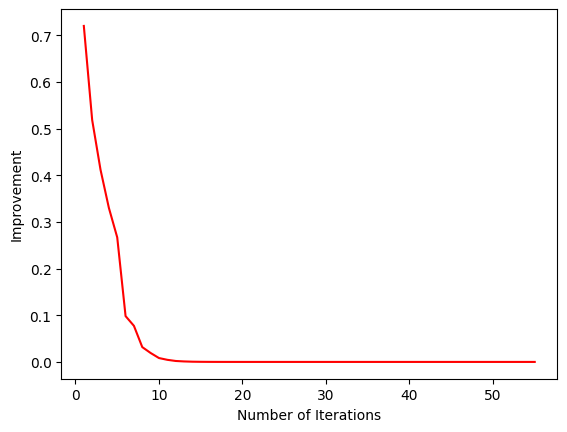

In [7]:
x = Gridworld(3,4,[0.1,0.8,0.1],0)
Gridworld.add_deer_hunter(x,[0,3],1,[1,3],-1)
Gridworld.add_lion(x, [2,0])
l = ValueIteration(x)
x.value_grid = ValueIteration.value_iteration(l,0.9,delta = 0,max_iteration=1000)
num_iter = list(range(1, len(l.performance)+1))
max_diff = l.performance
plt.plot(num_iter,max_diff,'r-')
plt.xlabel("Number of Iterations")
plt.ylabel("Improvement")
plt.show()

In [5]:
num_columns=[]
num_iter=[]
for i in range(7,17):
    x = Gridworld(i,i,[0.1,0.8,0.1],0)
    Gridworld.add_deer_hunter(x,[0,i-1],1,[1,i-1],-1)
    Gridworld.add_lion(x, [2,0])
    l = ValueIteration(x)
    x.value_grid = ValueIteration.value_iteration(l,0.9,delta = 0.001,max_iteration=1000)
    num_columns.append(i)
    num_iter.append(len(l.performance))

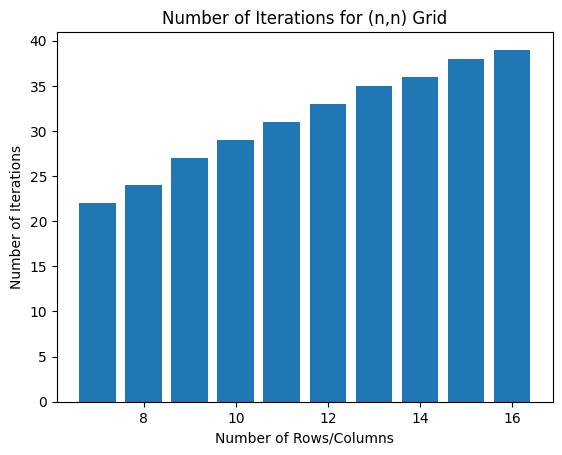

In [6]:
plt.bar(num_columns,num_iter)
plt.xlabel("Number of Rows/Columns")
plt.ylabel("Number of Iterations")
plt.title("Number of Iterations for (n,n) Grid")
plt.show()

In [7]:
x = Gridworld(8,8,[0.1,0.8,0.1],-0.1)
Gridworld.add_deer_hunter(x,[0,7],1,[1,7],-10)
Gridworld.add_lion(x, [7,0])
l = ValueIteration(x)
x.value_grid = ValueIteration.value_iteration(l,0.9, max_iteration=100)
ValueIteration.print_valuegrid(l)
A = Agent(x)

[-0.27623689 -0.16792285 -0.04266249  0.10239617  0.270711    0.46646835
  0.69599074  1.        ]
[ -0.33856752  -0.24547534  -0.13942322  -0.01923781   0.11655338
   0.25969858   0.1483508  -10.        ]
[-0.41071013 -0.33308357 -0.24147065 -0.13746539 -0.02090878  0.08382984
 -0.01412596 -0.31647988]
[-0.47565195 -0.41257638 -0.33274941 -0.24176243 -0.14266522 -0.06502513
 -0.13936365 -0.25934064]
[-0.53392838 -0.48228061 -0.41302164 -0.33374131 -0.25000404 -0.19164802
 -0.24810577 -0.33906165]
[-0.58609361 -0.54351691 -0.48362501 -0.41480884 -0.34431946 -0.29981881
 -0.34270468 -0.41205271]
[-0.63269555 -0.59739111 -0.54573418 -0.48620848 -0.4269991  -0.39255797
 -0.42509346 -0.47795226]
[-0.67399971 -0.64220486 -0.59811218 -0.54884128 -0.49934274 -0.47230582
 -0.49692273 -0.5371967 ]

['east' 'east' 'east' 'east' 'east' 'east' 'east' '0.0']
['east' 'east' 'east' 'east' 'north' 'north' 'north' '0.0']
['east' 'east' 'east' 'north' 'north' 'north' 'north' 'west']
['north' 'east' 'nor

(0.846, 17.327, 986, 14)

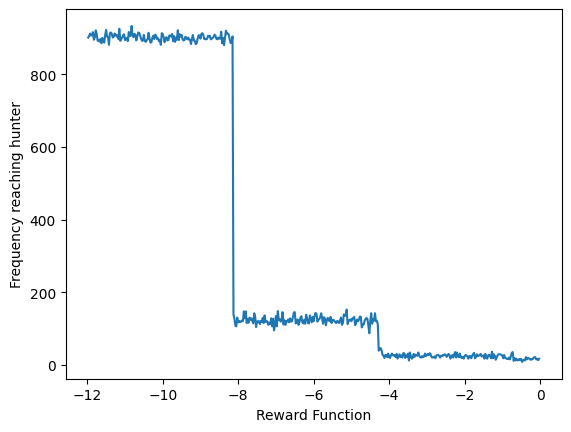

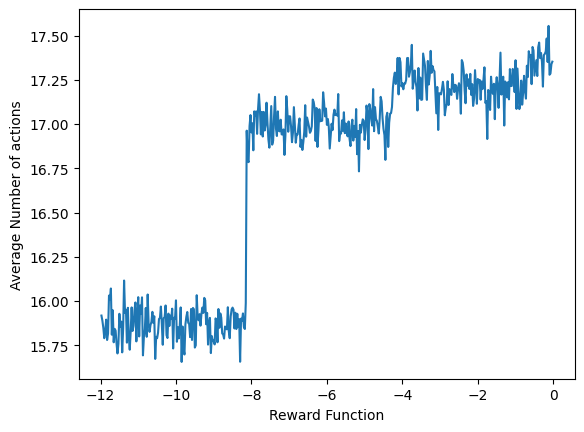

In [8]:
hunter = []
num_steps = []
for i in range(1,480):
    x = Gridworld(8,8,[0.1,0.8,0.1],-0.025*i)
    Gridworld.add_deer_hunter(x,[0,7],1,[1,7],-10)
    Gridworld.add_lion(x, [7,0])
    l = ValueIteration(x)
    x.value_grid = ValueIteration.value_iteration(l,0.9,delta = 0.0001)
    A = Agent(x)
    hunter.append(Agent.performance(A)[3])
    num_steps.append(Agent.performance(A)[1])
x = [i * -0.025 for i in list(range(1,480))]
plt.plot(x,hunter)
plt.xlabel("Reward Function")
plt.ylabel("Frequency reaching hunter")
plt.show()
plt.plot(x,num_steps)
plt.xlabel("Reward Function")
plt.ylabel("Average Number of actions")
plt.show()

In [31]:
x = Gridworld(8,8,[0.1,0.8,0.1],-5)
Gridworld.add_deer_hunter(x,[0,7],1,[1,7],-10)
Gridworld.add_lion(x, [7,0])
l = ValueIteration(x)
x.value_grid = ValueIteration.value_iteration(l,0.9,delta = 0.0001)
A = Agent(x)
Agent.print_policy(A)

['east' 'east' 'east' 'east' 'east' 'east' 'east' '0.0']
['east' 'east' 'east' 'east' 'east' 'east' 'north' '0.0']
['east' 'east' 'east' 'east' 'east' 'north' 'north' 'north']
['east' 'east' 'east' 'east' 'north' 'north' 'north' 'north']
['north' 'east' 'east' 'north' 'north' 'north' 'north' 'north']
['north' 'north' 'north' 'north' 'north' 'north' 'north' 'north']
['north' 'north' 'north' 'north' 'north' 'north' 'north' 'north']
['north' 'east' 'east' 'east' 'north' 'north' 'north' 'north']
 


In [32]:
x = Gridworld(8,8,[0.1,0.8,0.1],-3)
Gridworld.add_deer_hunter(x,[0,7],1,[1,7],-10)
Gridworld.add_lion(x, [7,0])
l = ValueIteration(x)
x.value_grid = ValueIteration.value_iteration(l,0.9,delta = 0.0001)
A = Agent(x)
Agent.print_policy(A)

['east' 'east' 'east' 'east' 'east' 'east' 'east' '0.0']
['east' 'east' 'east' 'east' 'east' 'north' 'north' '0.0']
['east' 'east' 'east' 'east' 'north' 'north' 'north' 'north']
['north' 'east' 'east' 'north' 'north' 'north' 'north' 'north']
['north' 'east' 'north' 'north' 'north' 'north' 'north' 'north']
['north' 'north' 'north' 'north' 'north' 'north' 'north' 'north']
['north' 'north' 'north' 'north' 'north' 'north' 'north' 'north']
['north' 'east' 'east' 'north' 'north' 'north' 'north' 'north']
 


In [6]:
x = Gridworld(4,4,[0.1,0.8,0.1],-0.1)
Gridworld.add_deer_hunter(x,[0,3],1,[1,3],-10)
Gridworld.add_lion(x, [3,0])
l = ValueIteration(x)
x.value_grid = ValueIteration.value_iteration(l,1,delta = 0)
A = Agent(x)
print(A.policy)
print(A.value_grid)
#Agent.performance(A,num_iterations=1)

[['east' 'east' 'east' '0.0']
 ['north' 'north' 'north' '0.0']
 ['north' 'north' 'north' 'west']
 ['north' 'north' 'north' 'west']]
[[  0.54360806   0.68264475   0.82635455   1.        ]
 [  0.43131454   0.53296635   0.43719098 -10.        ]
 [  0.31517661   0.38607318   0.28182439  -0.06535712]
 [  0.19611416   0.24361451   0.15144548   0.01624519]]


In [18]:
x = Gridworld(3,4,[0.1,0.8,0.1],-0.1)
Gridworld.add_deer_hunter(x,[0,3],1,[1,3],-10)
Gridworld.add_lion(x, [2,0])
l = ValueIteration(x)
x.value_grid = ValueIteration.value_iteration(l,0.001,delta = 0.00000001)
A = Agent(x)
A.value_grid

array([[ -0.1001001 ,  -0.1000994 ,  -0.09921993,   1.        ],
       [ -0.1001001 ,  -0.1001001 ,  -0.10010001, -10.        ],
       [ -0.1001001 ,  -0.1001001 ,  -0.1001001 ,  -0.1001001 ]])